In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

# Comparacion de Resultados GRD y DEIS

En este cuadernillo se quieren calcular las diferencias entre las bases de egresos hospitalarios GRD y DEIS. Se compararán:

1. Cantidad de egresos hospitalarios
2. Ranking para cada uno de los diagnósticos

Este análisis se realizará a nivel Nacional y a nivel del Hospital del Tórax

In [17]:
# Lee ranking de egresos DEIS
ranking_egresos_nacionales_deis = pl.read_csv(
    "../data/external/ranking_nacional_egresos.csv", encoding="latin-1", separator=";"
).to_pandas()

# Solo deja los estblecimientos publicos en DEIS
ranking_egresos_publicos_deis = ranking_egresos_nacionales_deis.dropna(
    subset="ranking_publicos_n_egresos"
).copy()

# Lee ranking de egresos GRD
ranking_egresos_nacionales_grd = pl.read_csv(
    "../data/interim/ranking_nacionales_egresos_grd.csv", separator=";"
).to_pandas()

In [18]:
# Define columnas a analizar entre ambas bases
COLUMNAS_A_SELECCIONAR = [
    "ANIO_EGRESO",
    "COD_HOSPITAL",
    "DIAGNOSTICO1",
    "Capítulo",
    "Sección",
    "Categoría",
    "Descripción",
    "GLOSA_ESTABLECIMIENTO_SALUD",
    "n_egresos_GRD",
    "n_egresos_DEIS",
    "ranking_egresos",
    "ranking_grd_n_egresos",
    "dias_estada_totales_GRD",
    "dias_estada_totales_DEIS",
    "ranking_nacionales_n_egresos",
    "ranking_publicos_n_egresos",
]

# Une ambas bases de datos segun el anio, hospital y diagnostico principal
comparacion_grd_deis_pais = (
    ranking_egresos_nacionales_grd.merge(
        ranking_egresos_nacionales_deis,
        left_on=["ANIO_EGRESO", "COD_HOSPITAL", "DIAGNOSTICO1"],
        right_on=["ANO_EGRESO", "ESTABLECIMIENTO_SALUD", "DIAG1"],
        how="inner",
        suffixes=("_GRD", "_DEIS"),
    )[COLUMNAS_A_SELECCIONAR]
)

# Obtiene comparacion de egresos solamente para el Torax
comparacion_grd_deis_torax = comparacion_grd_deis_pais.query("COD_HOSPITAL == 112103").copy()

In [19]:
DIFERENCIAS_A_CALCULAR = [
    ("n_egresos_GRD", "n_egresos_DEIS"),
    ("ranking_egresos", "ranking_grd_n_egresos"),
]

# Calcula diferencias entre egresos y rankings a nivel pais y Torax
comparacion_grd_deis_torax = build_features.calculate_and_add_difference(
    comparacion_grd_deis_torax, DIFERENCIAS_A_CALCULAR
)

comparacion_grd_deis_pais = build_features.calculate_and_add_difference(
    comparacion_grd_deis_pais, DIFERENCIAS_A_CALCULAR
)

In [20]:
# Obtiene el promedio de las diferencias de egresos
diferencia_promedio_egresos_torax = comparacion_grd_deis_torax[
    "n_egresos_GRD_n_egresos_DEIS_difference"
].mean()

# Obtiene el promedio de las diferencias de rankings
diferencia_promedio_ranking_torax = comparacion_grd_deis_torax[
    "ranking_egresos_ranking_grd_n_egresos_difference"
].mean()

print(f"> {diferencia_promedio_egresos_torax=:.2f} egresos")
print(f"> {diferencia_promedio_ranking_torax=:.2f} posiciones")

> diferencia_promedio_egresos_torax=3.08 egresos
> diferencia_promedio_ranking_torax=4.46 posiciones


In [21]:
# Obtiene el promedio de las diferencias de egresos
diferencia_promedio_egresos_pais = comparacion_grd_deis_pais[
    "n_egresos_GRD_n_egresos_DEIS_difference"
].mean()

# Obtiene el promedio de las diferencias de rankings
diferencia_promedio_ranking_pais = comparacion_grd_deis_pais[
    "ranking_egresos_ranking_grd_n_egresos_difference"
].mean()

print(f"> {diferencia_promedio_egresos_pais=:.2f} egresos")
print(f"> {diferencia_promedio_ranking_pais=:.2f} posiciones")

> diferencia_promedio_egresos_pais=6.95 egresos
> diferencia_promedio_ranking_pais=6.14 posiciones


# Diferencias en cantidad de Hospitales presentes

In [22]:
cantidad_hospitales_totales_deis = (
    ranking_egresos_nacionales_deis.groupby("ANO_EGRESO")["ESTABLECIMIENTO_SALUD"]
    .nunique()
    .to_frame()
)

cantidad_hospitales_publicos_deis = (
    ranking_egresos_publicos_deis.groupby("ANO_EGRESO")["ESTABLECIMIENTO_SALUD"]
    .nunique()
    .to_frame()
)

cantidad_hospitales_grd = (
    ranking_egresos_nacionales_grd.groupby("ANIO_EGRESO")["COD_HOSPITAL"].nunique().to_frame()
)

comparacion_cantidad_de_hospitales = cantidad_hospitales_totales_deis.merge(
    cantidad_hospitales_publicos_deis, how="inner", left_index=True, right_index=True
).merge(cantidad_hospitales_grd, how="inner", left_index=True, right_index=True)

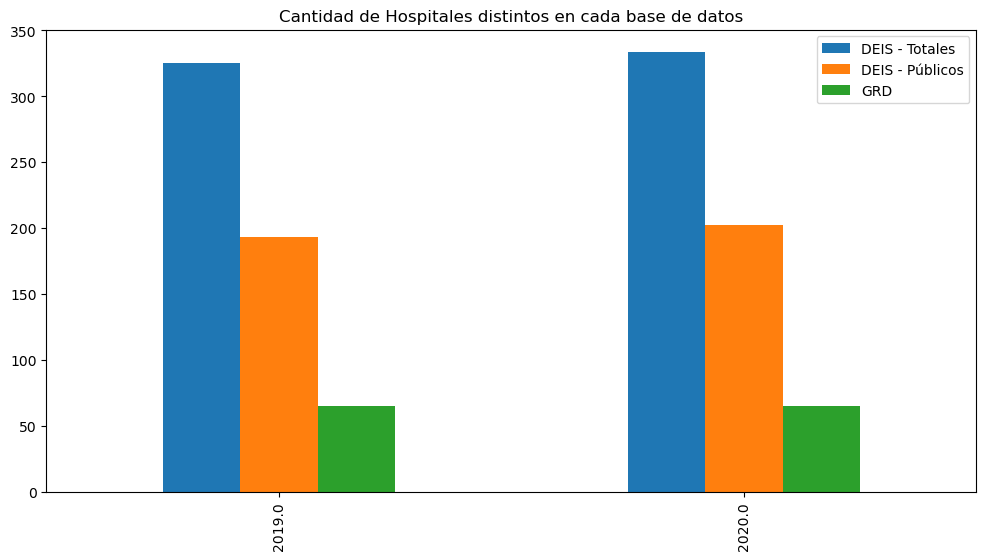

In [24]:
axis = comparacion_cantidad_de_hospitales.plot(kind="bar")
axis.legend(labels=["DEIS - Totales", "DEIS - Públicos", "GRD"])
plt.title("Cantidad de Hospitales distintos en cada base de datos")
plt.show()